# Impact of $c_s^2$ on observables

Usual dark energy models assume an effective sound speed of $c_s^2 = 1$. What is the impact of another choice, *e.g.* $c_s^2 = 0$?

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import camb

matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["legend.framealpha"] = 0.0

In [2]:
# Cosmological parameters for examples
H0 = 67
omegam = 0.319
omegab = 0.049
As = 2.1e-9
ns = 0.96
tau = 0.07

dark_energy_types = ["desi_pp_mean", "wcdm"]
dark_energy_type = "desi_pp_mean"

if dark_energy_type == "desi_pp_mean":
    # DESI DR2 BAO + CMB + Pantheon+ mean
    w0 = -0.838
    wa = -0.62
elif dark_energy_type == "wcdm":
    w0 = -0.8
    wa = 0
else:
    raise Exception(f"Unsupported dark_energy_type {dark_energy_type}; supported values are {dark_energy_types}.")

# Derived parameters
h = H0/100
omegac = omegam - omegab
ombh2 = omegab*h*h
omch2 = omegac*h*h

# k, z grid for power spectrum
ks = np.logspace(-4, -0.9, 256)
redshifts = np.linspace(0, 3, 256)

In [6]:
cases = {
    "quint":     {"label": "$c_s^2 = 1$",       "cs2_0": 1   },
    "clust1e-1": {"label": "$c_s^2 = 10^{-1}$", "cs2_0": 1e-1},
    "clust1e-2": {"label": "$c_s^2 = 10^{-3}$", "cs2_0": 1e-3},
    "clust1e-3": {"label": "$c_s^2 = 10^{-5}$", "cs2_0": 1e-5},
}

def get_observables(case):
    cosmo = camb.set_params(
        H0=H0, ombh2=ombh2, omch2=omch2, As=As, ns=ns, tau=tau,
        num_nu_massless=3.044, omnuh2=0, WantTransfer=True, w=w0, wa=wa,
        dark_energy_model="fluid" if dark_energy_type == "wcdm" else "ppf",
        cs2_0=case["cs2_0"]
    )
    cosmo.set_for_lmax(2000, lens_potential_accuracy=1)
    cosmo.set_matter_power(redshifts=redshifts, kmax=20, silent=True, nonlinear=None)
    results = camb.get_results(cosmo)
    P_lin = results.get_matter_power_interpolator(nonlinear=None).P(redshifts, ks)
    cl_tt = results.get_lensed_scalar_cls(CMB_unit='muK')[:,0]
    cl_ee = results.get_lensed_scalar_cls(CMB_unit='muK')[:,1]
    cl_te = results.get_lensed_scalar_cls(CMB_unit='muK')[:,3]
    cl_pp = results.get_lens_potential_cls(lmax=2000)[:,0]
    log_a = results.Params.log_a
    mu = results.Params.mu
    case.update({"P_lin": P_lin, "cl_tt": cl_tt, "cl_ee": cl_ee, "cl_te": cl_te, "cl_pp": cl_pp, "log_a": log_a, "mu": mu})

data = {}
for name, case in cases.items():
    get_observables(case)

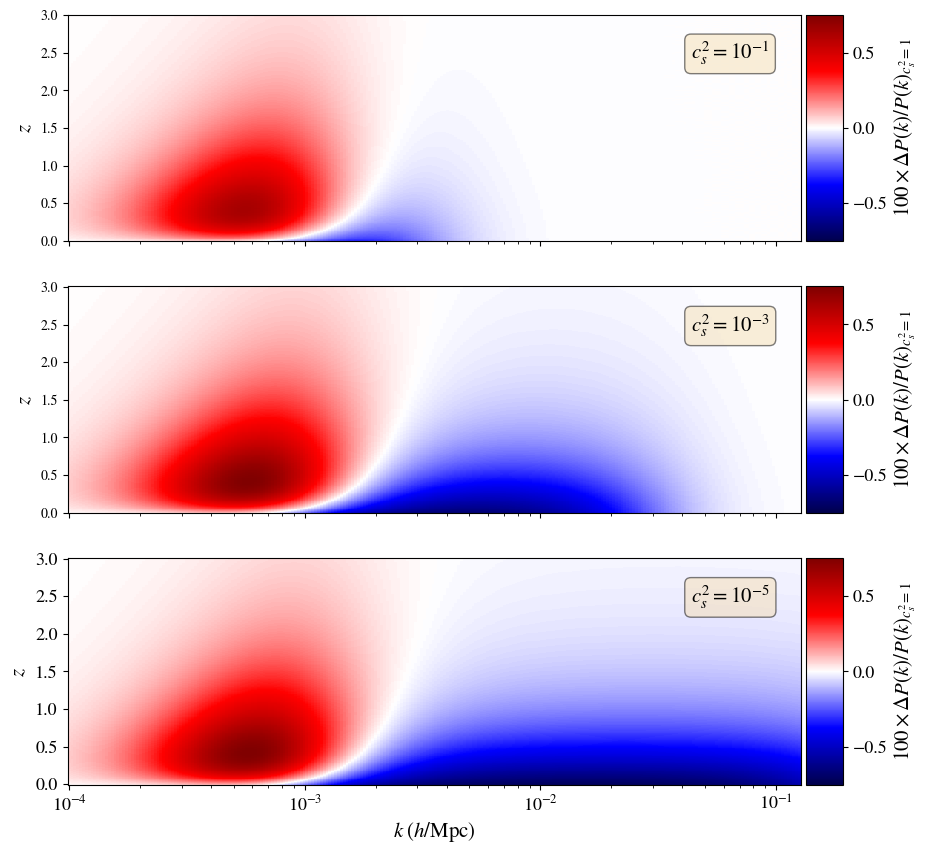

In [42]:
# Plot P(k)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize

# Precomputing min and max relative errors for unifying the colormaps in each axis
fig, axs = plt.subplots(len(cases)-1, 1, sharex=True, sharey=True, figsize=(10, 10))
scale = -np.inf
for name, case in cases.items():
    if name == "quint": continue
    relative_errors = 100*(np.abs(case["P_lin"]/cases["quint"]["P_lin"] - 1))
    scale = max(scale, np.amax(relative_errors))

norm = Normalize(vmin=-scale, vmax=scale)

for i, (name, case) in enumerate(cases.items()):
    if name == "quint": continue
    ax = axs[i-1]
    relative_errors = 100*(case["P_lin"]/cases["quint"]["P_lin"] - 1)
    mesh = ax.pcolormesh(ks, redshifts, relative_errors, cmap="seismic", norm=norm)
    ax.set_xscale('log')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(mesh, cax=cax, orientation="vertical")
    cax.set_ylabel(r"$100 \times \Delta P(k)/P(k)_{c_s^2 = 1}$", fontsize=15)
    cax.tick_params(labelsize=13)
    ax.set_ylabel(r"$z$", fontsize=15)
    ax.text(0.85, 0.8, case["label"], transform=ax.transAxes, bbox={'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.5}, fontsize=15)

axs[-1].tick_params(labelsize=13)
axs[-1].set_xlabel(r"$k \; (h/\mathrm{Mpc})$", fontsize=15)
plt.savefig("plots/cs2_impact_pk_ppf.png", bbox_inches="tight")

/tmp/ipykernel_17114/356066770.py:19: RuntimeWarning: invalid value encountered in divide
  axs[0, 0].semilogx(ells_tt, 100*(case["cl_tt"]/cases["quint"]["cl_tt"] - 1), label=case["label"], **style)
/tmp/ipykernel_17114/356066770.py:20: RuntimeWarning: invalid value encountered in divide
  axs[0, 1].semilogx(ells_pp, 100*(case["cl_pp"]/cases["quint"]["cl_pp"] - 1), label=case["label"], **style)
/tmp/ipykernel_17114/356066770.py:21: RuntimeWarning: invalid value encountered in divide
  axs[1, 0].semilogx(ells_tt, 100*(case["cl_ee"]/cases["quint"]["cl_ee"] - 1), label=case["label"], **style)


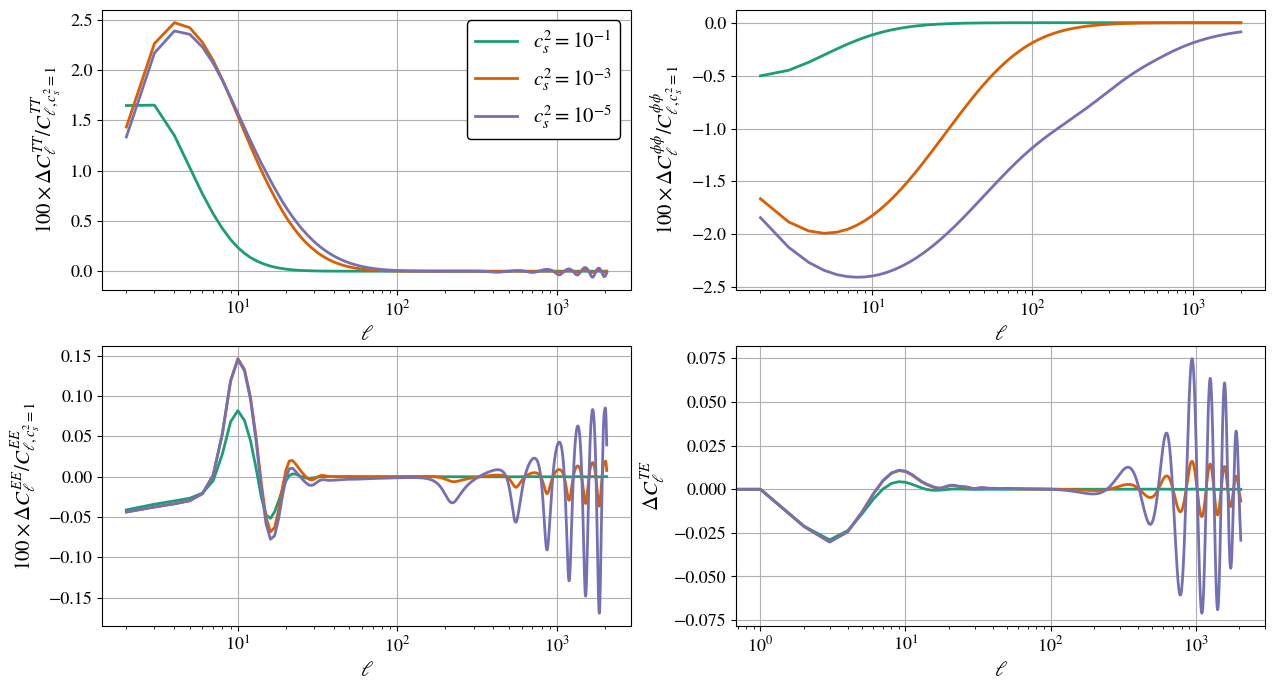

In [ ]:
# Plot CMB
fig, axs = plt.subplots(2, 2, figsize=(15, 8), gridspec_kw={'wspace': 0.2, 'hspace': 0.2})
ells_tt = np.arange(2051)
ells_pp = np.arange(2001)

# Generated from https://colorbrewer2.org/#type=sequential&scheme=OrRd&n=4
styles = [
    {},
    {"lw": 2, "color": "#1b9e77"},
    {"lw": 2, "color": "#d95f02"},
    {"lw": 2, "color": "#7570b3"},
]

for style, (name, case) in zip(styles, cases.items()):
    if name == "quint": continue
    axs[0, 0].semilogx(ells_tt, 100*(case["cl_tt"]/cases["quint"]["cl_tt"] - 1), label=case["label"], **style)
    axs[0, 1].semilogx(ells_pp, 100*(case["cl_pp"]/cases["quint"]["cl_pp"] - 1), label=case["label"], **style)
    axs[1, 0].semilogx(ells_tt, 100*(case["cl_ee"]/cases["quint"]["cl_ee"] - 1), label=case["label"], **style)
    axs[1, 1].semilogx(ells_tt, case["cl_te"] - cases["quint"]["cl_te"],   label=case["label"], **style)

axs[0, 0].set_xlabel(r"$\ell$", fontsize=15)
axs[0, 0].set_ylabel(r"$100 \times \Delta C_\ell^{TT}/C_{\ell, c_s^2=1}^{TT}$", fontsize=15)
axs[0, 1].set_xlabel(r"$\ell$", fontsize=15)
axs[0, 1].set_ylabel(r"$100 \times \Delta C_\ell^{\phi\phi}/C_{\ell, c_s^2=1}^{\phi\phi}$", fontsize=15)
axs[1, 0].set_xlabel(r"$\ell$", fontsize=15)
axs[1, 0].set_ylabel(r"$100 \times \Delta C_\ell^{EE}/C_{\ell, c_s^2=1}^{EE}$", fontsize=15)
axs[1, 1].set_xlabel(r"$\ell$", fontsize=15)
axs[1, 1].set_ylabel(r"$\Delta C_\ell^{TE}$", fontsize=15)
axs[0, 0].legend(fontsize=15, frameon=True, framealpha=1, edgecolor="black")
for ax in axs.flatten():
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.grid()
plt.savefig("plots/cs2_impact_cmb_ppf.pdf", bbox_inches="tight")